In [31]:
from nmm import csolve,OhmicBath,OverdampedBath
from qutip import Qobj,sigmaz,sigmax,sigmay
import numpy as np
import matplotlib.pyplot as plt

In [32]:
w0 = 1
alpha = 0.01
gamma = 5
T = 1*w0
tf = 40
t=np.linspace(0,tf,200)
Hsys = sigmaz()/2
Q = sigmax()

In [33]:
bath=OverdampedBath(T,alpha,gamma)
bath2 = OverdampedBath(2*T,alpha,gamma)

In [34]:
bath.power_spectrum(1)

0.012169051591302512

In [35]:
bath2.power_spectrum(1)

0.019549954481052293

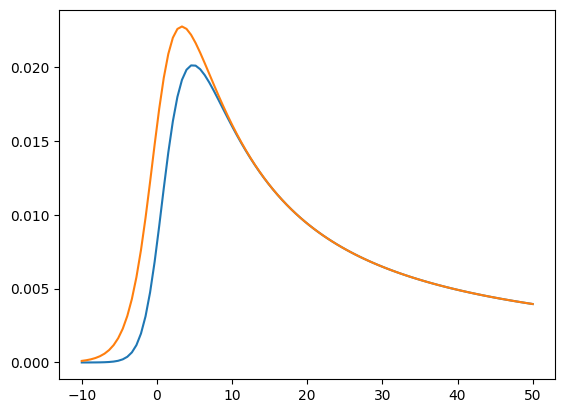

In [36]:
w=np.linspace(-10,50,100)
plt.plot(w,bath.power_spectrum(w))
plt.plot(w,bath2.power_spectrum(w))
plt.show()

In [37]:
#cc = csolve(Hsys,t ,[bath,bath2], [Q,Q])
cc2 = csolve(Hsys, t ,[bath,bath2], [Q,Q],eps=1e-5)

In [38]:
rho0=0.5*Qobj([[1,1],[1,1]])

In [39]:
result=cc2.evolution(rho0)
#result2=cc.evolution(rho0)

2


Calculating the generator ...: 100%|██████████| 4/4 [00:00<00:00, 2377.05it/s]


2


Computing Exponential of Generators . . . .: 100%|██████████| 200/200 [00:00<00:00, 5585.59it/s]


In [40]:
cc2.generators[10]

Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', isherm=False
Qobj data =
[[-0.18653745+0.j          0.        +0.j          0.        +0.j
   0.10797521+0.j        ]
 [ 0.        +0.j         -0.14725633+0.j         -0.02981692-0.06345788j
   0.        +0.j        ]
 [ 0.        +0.j         -0.02981692+0.06345788j -0.14725633+0.j
   0.        +0.j        ]
 [ 0.18653745+0.j          0.        +0.j          0.        +0.j
  -0.10797521+0.j        ]]

In [41]:
def population(den, a, b):
    return [den[i][a, b] for i in range(len(den))]

In [42]:
# bath = DrudeLorentzPadeBath(Q=Q, lam=alpha*np.pi, gamma=gamma, T=T, Nk=8)
# solver = HEOMSolver(Hsys, bath, max_depth=5)
# result_h = solver.run(rho0, t)

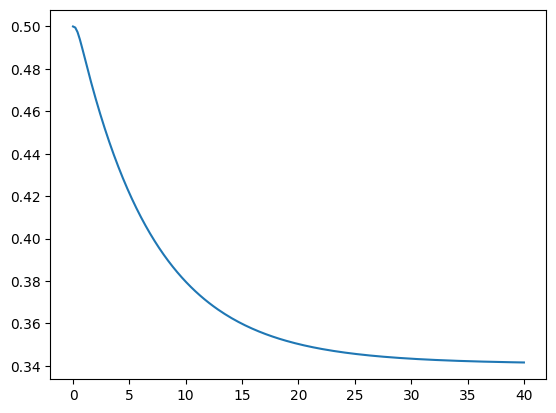

In [43]:
i,j=0,0
plt.plot(t,np.abs(population(result,i,j)))
#plt.plot(t, np.abs(population(result2, i, j)))
# plt.plot(t, np.abs(population(result_h.states, 0, 1)))
# plt.show()

In [44]:
from qutip import brmesolve

In [45]:
from qutip.solver import heom

In [46]:
obp=heom.SpectralFitter(T,Q,w,bath.spectral_density(w)*np.pi)
obp2=heom.SpectralFitter(2*T,Q,w,bath.spectral_density(w)*np.pi)


In [47]:
bathf,fit_info=obp.get_fit(N=7,Nk=4)
bathf2,fit_info=obp2.get_fit(N=7,Nk=2)

fit_info

{'fit_time': 1.9633121490478516,
 'rmse': 7.277626743502294e-07,
 'N': 7,
 'params': [array([0.47504699, 3.14019328, 1.72696246, 3.14019328, 3.14019328,
         3.14019328, 3.14019328]),
  array([ 5.50035657, 19.63363942,  8.75196868, 18.40805345, 13.60054622,
         18.47976369, 14.62539057]),
  array([ 0.51515152, 29.62500064,  0.51515152, 17.18767892, 56.09698471,
         42.72379424,  6.21563832])],
 'Nk': 2,
 'summary': 'Result of fitting The Spectral Density with 7 terms: \n \n Parameters|   lam    |  gamma   |   w0 \n 1         | 4.75e-01 | 5.50e+00 |5.15e-01\n 2         | 3.14e+00 | 1.96e+01 |2.96e+01\n 3         | 1.73e+00 | 8.75e+00 |5.15e-01\n 4         | 3.14e+00 | 1.84e+01 |1.72e+01\n 5         | 3.14e+00 | 1.36e+01 |5.61e+01\n 6         | 3.14e+00 | 1.85e+01 |4.27e+01\n 7         | 3.14e+00 | 1.46e+01 |6.22e+00\n \nA  normalized RMSE of  7.28e-07 was obtained for the The Spectral Density\n The current fit took  1.963312 seconds'}

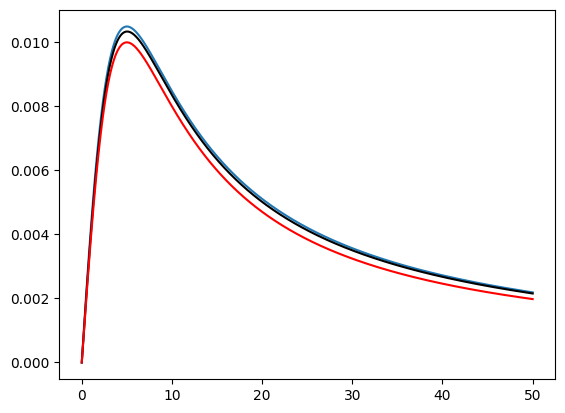

In [48]:
w=np.linspace(0,50,1000)
plt.plot(w,bathf.spectral_density_approx(w)/np.pi)
plt.plot(w,bathf2.spectral_density_approx(w)/np.pi,color='k')
plt.plot(w,bath.spectral_density(w),color='r')

In [49]:
solver = heom.HEOMSolver(Hsys,[bathf2,bathf],max_depth=3)

In [50]:
result_heom=solver.run(rho0,t)

10.1%. Run time:   6.45s. Est. time left: 00:00:00:57
20.1%. Run time:  13.27s. Est. time left: 00:00:00:52
30.2%. Run time:  19.73s. Est. time left: 00:00:00:45
40.2%. Run time:  26.35s. Est. time left: 00:00:00:39
50.3%. Run time:  32.83s. Est. time left: 00:00:00:32
60.3%. Run time:  39.19s. Est. time left: 00:00:00:25
70.4%. Run time:  45.40s. Est. time left: 00:00:00:19
80.4%. Run time:  51.71s. Est. time left: 00:00:00:12
90.5%. Run time:  58.12s. Est. time left: 00:00:00:06
100.0%. Run time:  64.43s. Est. time left: 00:00:00:00
Total run time:  64.43s


In [51]:
def br(rho0,sec=-1):
    a_ops = [[Q,bathf.power_spectrum],[Q,bathf2.power_spectrum]]
    resultBR = brmesolve(
        Hsys, rho0, t, a_ops=a_ops,sec_cutoff=sec
    )
    return resultBR

In [52]:
resultBR=br(rho0)

In [53]:
from scipy import linalg

In [54]:
def rotation(data, t, diagonal=True):
    rotated = [
        linalg.expm(-(1j * Hsys.full()) * t[i])
        @ data[i].full()
        @ linalg.expm((1j * Hsys.full()) * t[i])
        for i in range(len(t))
    ]
    return rotated

cum=rotation(result,t)

In [55]:
import qutip as qt

In [56]:
n1=bath.bose(w0)
n2=bath2.bose(w0)
spc=bath.spectral_density(w0)
Q1=(sigmax()+1j*sigmay())/2
c_ops=[np.sqrt(2*np.pi*(n1)*spc)*(Q1),np.sqrt(2*np.pi*(n1+1)*spc)*(Q1.dag()),
       np.sqrt(2*np.pi*(n2)*spc)*(Q1),np.sqrt(2*np.pi*(n2+1)*spc)*(Q1.dag())]
result_lindblad = qt.mesolve(Hsys, rho0, t, c_ops)

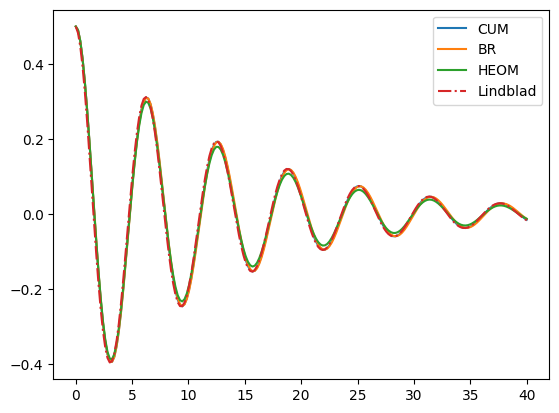

In [58]:
i,j=0,1
plt.plot(t, np.real(population(cum, i, j)),label='CUM')
plt.plot(t, np.real(population(resultBR.states, i, j)),label='BR')
plt.plot(t, np.real(population(result_heom.states, i, j)),label='HEOM')
plt.plot(t, np.real(population(result_lindblad.states, i, j)),'-.',label='Lindblad')
#plt.axhline(y=0.339921666085097,linestyle='-.')
plt.legend()
plt.show()